In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import simple_norm
import astropy.units as u 
from astropy.coordinates import SkyCoord
import regions
from regions import Regions

from spectral_cube import SpectralCube

In [2]:
cd ..

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [3]:
import moment_maker as mm
from jwst_plots import JWSTCatalog, make_cat_use

In [4]:
cd notebooks/

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


# CO Files

In [5]:
fn_12CO = '/orange/adamginsburg/cmz/nobeyama/12CO-2.BEARS.FITS'
fn_13CO = '/orange/adamginsburg/cmz/nobeyama/13CO-2.FOREST.FITS'
fn_C18O = '/orange/adamginsburg/cmz/nobeyama/C18O-2.FOREST.FITS'

In [6]:
cube_12CO = SpectralCube.read(fn_12CO, format='fits')
cube_13CO = SpectralCube.read(fn_13CO, format='fits')
cube_C18O = SpectralCube.read(fn_C18O, format='fits')

In [7]:
subcube_12CO = cube_12CO.spectral_slab(0*u.km/u.s, 50*u.km/u.s)
subcube_13CO = cube_13CO.spectral_slab(0*u.km/u.s, 50*u.km/u.s)
subcube_C18O = cube_C18O.spectral_slab(0*u.km/u.s, 50*u.km/u.s)

In [8]:
reg = Regions.read('/orange/adamginsburg/jwst/cloudc/regions_/f4_fov_cloudc.reg')

In [9]:
mom0_12CO = subcube_12CO.subcube_from_regions(reg).moment0()
mom0_13CO = subcube_13CO.subcube_from_regions(reg).moment0()
mom0_C18O = subcube_C18O.subcube_from_regions(reg).moment0()

# Catalog

In [10]:
cat_use = make_cat_use()

In [11]:
reg_filament = Regions.read(f'../regions_/filament_short.region')

cat_filament = JWSTCatalog(cat_use.table_region_mask(reg_filament, wcs=mom0_12CO.wcs))

In [12]:
basetable = cat_use.catalog

## Av

In [13]:
from dust_extinction.averages import CT06_MWGC
av182410 = (basetable['mag_ab_f182m'] - basetable['mag_ab_f410m']) / (CT06_MWGC()(1.82*u.um) - CT06_MWGC()(4.10*u.um))
a182 = CT06_MWGC()(1.82*u.um)
f182mdr = basetable['mag_ab_f182m'] - a182 * av182410

# Select Region of CO Data

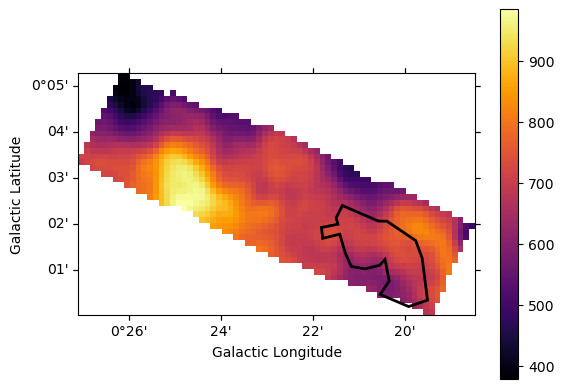

In [14]:
ax = plt.subplot(projection=mom0_12CO.wcs)
im = ax.imshow(mom0_12CO.value, origin='lower', cmap='inferno', norm=simple_norm(mom0_12CO.value, stretch='linear', max_percent=99.9))
plt.colorbar(im)
#reg[0].to_pixel(mom0_12CO.wcs).plot(ax=ax, edgecolor='k')
reg_filament[0].to_pixel(mom0_12CO.wcs).plot(ax=ax, edgecolor='k')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')

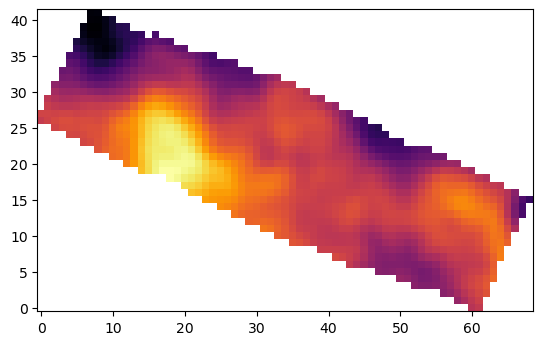

In [15]:
#ax = plt.subplot(projection=mom0_12CO.wcs)
im = plt.imshow(mom0_12CO.value, origin='lower', cmap='inferno', norm=simple_norm(mom0_12CO.value, stretch='linear', max_percent=99.9))
#plt.colorbar(im)
#reg[0].to_pixel(mom0_12CO.wcs).plot(ax=ax, edgecolor='k')
#plt.xlabel('Galactic Longitude')
#plt.ylabel('Galactic Latitude')

In [17]:
ww_12CO = mom0_12CO.wcs
crds_pix_12CO = np.array(ww_12CO.world_to_pixel(basetable['skycoord_ref']))

ww_13CO = mom0_13CO.wcs
crds_pix_13CO = np.array(ww_13CO.world_to_pixel(basetable['skycoord_ref']))

ww_C18O = mom0_C18O.wcs
crds_pix_C18O = np.array(ww_C18O.world_to_pixel(basetable['skycoord_ref']))

In [22]:
tbl = basetable.copy()
#tbl['W_12CO'] = 
tbl['mom0_12CO'] = mom0_12CO.value[crds_pix_12CO[1].astype(int), crds_pix_12CO[0].astype(int)]
tbl['mom0_13CO'] = mom0_13CO.value[crds_pix_13CO[1].astype(int), crds_pix_13CO[0].astype(int)]
tbl['mom0_C18O'] = mom0_C18O.value[crds_pix_C18O[1].astype(int), crds_pix_C18O[0].astype(int)]
tbl['Av'] = av182410
tbl['182m410'] = tbl['mag_ab_f182m'] - tbl['mag_ab_f410m']
tbl['H2 cm-2'] = tbl['mom0_12CO']*1e19*u.cm**-2/(u.K*u.km/u.s)

(0.0, 60.0)

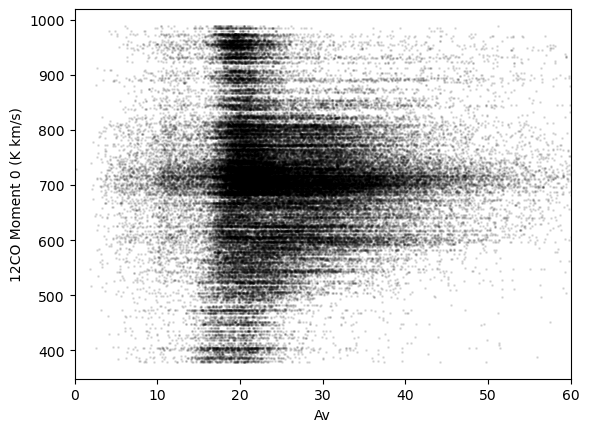

In [19]:
plt.scatter(tbl['Av'], tbl['mom0_12CO'], s=1, alpha=0.1, color='k')
plt.xlabel('Av')
plt.ylabel('12CO Moment 0 (K km/s)')
plt.xlim(0, 60)

(0.0, 60.0)

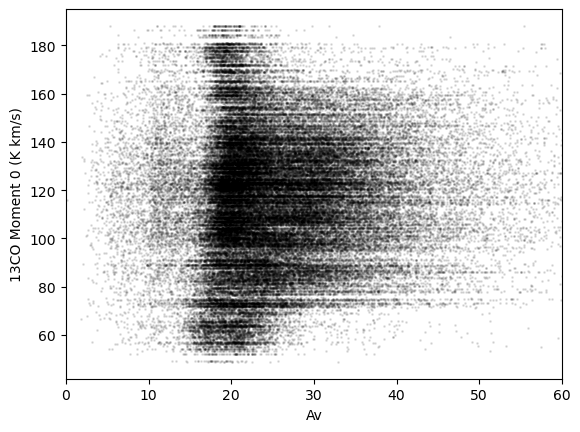

In [20]:
plt.scatter(tbl['Av'], tbl['mom0_13CO'], s=1, alpha=0.1, color='k')
plt.xlabel('Av')
plt.ylabel('13CO Moment 0 (K km/s)')
plt.xlim(0, 60)

(0.0, 60.0)

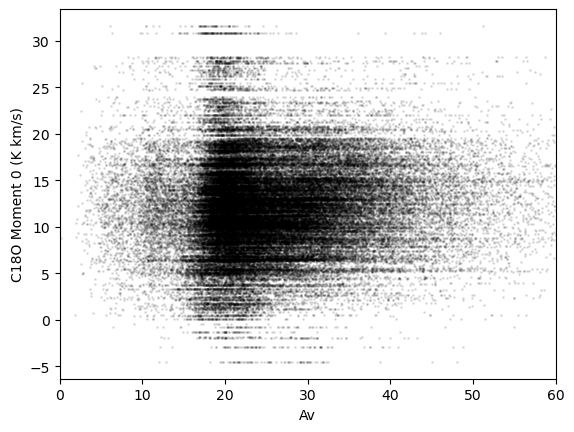

In [21]:
plt.scatter(tbl['Av'], tbl['mom0_C18O'], s=1, alpha=0.1, color='k')
plt.xlabel('Av')
plt.ylabel('C18O Moment 0 (K km/s)')
plt.xlim(0, 60)

(0.0, 75.0)

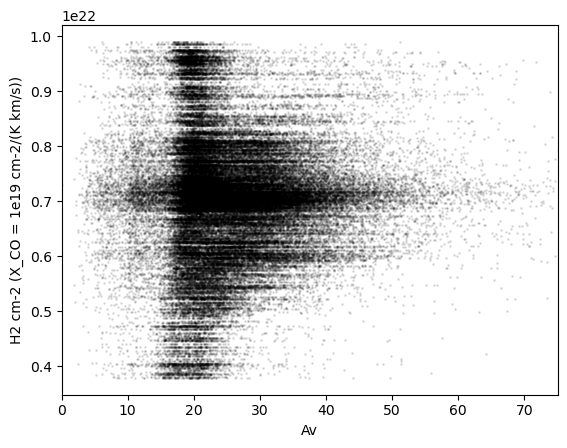

In [24]:
plt.scatter(tbl['Av'], tbl['H2 cm-2'], s=1, alpha=0.1, color='k')
plt.xlabel('Av')
plt.ylabel('H2 cm-2 (X_CO = 1e19 cm-2/(K km/s))')
plt.xlim(0, 75)

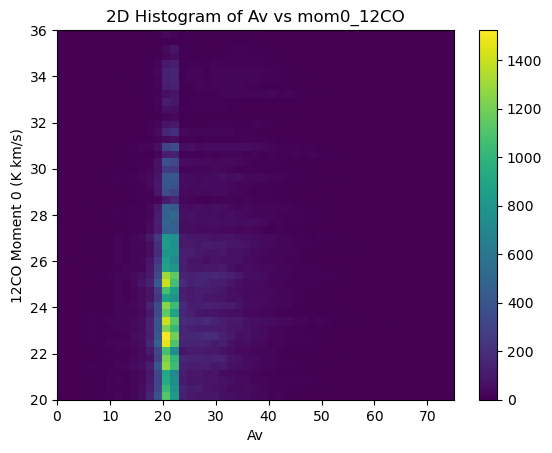

In [97]:
xbins = np.linspace(0, 75, 50)
ybins = np.linspace(20, 36, 50)

h, xedges, yedges = np.histogram2d(tbl['Av'], tbl['mom0_12CO'], bins=[xbins, ybins])

plt.imshow(h.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', origin='lower')#, norm=simple_norm(h, stretch='log', max_percent=99.9))

plt.colorbar()
plt.xlabel('Av')
plt.ylabel('12CO Moment 0 (K km/s)')
plt.title('2D Histogram of Av vs mom0_12CO')
plt.show()